In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch

from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig, RobertaTokenizerFast
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.12.1+cu113 Device: cuda [Tesla T4]


#Loading the multilingual dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_ml = pd.read_csv('/content/drive/MyDrive/Progetto_TA_2022/df_tot.csv')

In [6]:
df_ml.shape

(290183, 5)

In [7]:
df_ml.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [8]:
df_ml['Genre'].value_counts() #Genre distribution in training set

Rock          121404
Pop           108714
Metal          20291
Jazz           13545
Folk            8644
Indie           8449
R&B             2793
Hip-Hop         2240
Electronic      2213
Country         1890
Name: Genre, dtype: int64

In [9]:
df_ml['Genre'].isnull().values.any() #Checking the Genre column on having all valid records

False

In [10]:
df_ml['Language'].isnull().values.any()

True

In [11]:
df_ml['Lyrics'].isnull().values.any()

True

In [12]:
df_ml.dropna(subset = ['Language'], inplace=True) #eliminating the rows with NaN values in Language and Lyrics 


In [13]:
df_ml.dropna(subset = ['Lyrics'], inplace=True)

In [14]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

In [15]:
df_ml.shape

(290144, 5)

In [16]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

In [17]:
df_ml.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


Creating a 3 label dataset (most frequent)

In [18]:
most_frequent_genres=['Rock', 'Pop', 'Metal']
df_ml_3 = df_ml[df_ml['Genre'].isin(most_frequent_genres)]

In [19]:
labels = df_ml_3['Genre'].unique()

In [20]:
plt.rcParams["figure.figsize"] = [12,8]
colors = ['#05c9f0', '#00f6fa', '#6f8eec']
plt.pie(df_ml_3['Genre'].value_counts(), labels =labels, autopct = '%1.1f%%',colors = colors, shadow = True)
plt.title('Genre Distribution')

Text(0.5, 1.0, 'Genre Distribution')

#Splitting the dataset in training set and test set

In [21]:
import sklearn
from sklearn.model_selection import train_test_split

In [22]:
ml_train, ml_test = sklearn.model_selection.train_test_split(df_ml_3, test_size=0.20, train_size=0.80)

In [23]:
ml_train.shape, ml_test.shape

((200296, 5), (50074, 5))

In [24]:
x_train = ml_train['Lyrics']
y_train = ml_train['Genre']

x_test = ml_test['Lyrics']
y_test = ml_test['Genre']

#Generating numerical labels

In [25]:
import numpy as np

label_map = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
print(label_map)

y_train_vect = np.asarray([label_map[label] for label in y_train])
y_test_vect = np.asarray([label_map[label] for label in y_test])

y_train_vect,y_test_vect

{'Metal': 0, 'Pop': 1, 'Rock': 2}


(array([1, 2, 2, ..., 2, 2, 1]), array([2, 1, 2, ..., 1, 1, 2]))

#Text Pre-processing 

In [26]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = y_train_vect
labels_test  = y_test_vect

In [27]:
from transformers import BertModel
BERTMODEL = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(BERTMODEL)
model = BertModel.from_pretrained(BERTMODEL)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 50074/50074 [02:50<00:00, 292.93it/s]


In [29]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'Di', '##ve', 'in', 'and', 'show', 'me', 'your', 'depth', 'Can', 'you', 'look', 'inside', 'an', 'ang', '##els', 'eyes', 'And', 'see', 'a', 'wave', 'of', 'fear', '?', 'Something', 'may', 'not', 'be', 'as', 'pure', 'As', 'she', 'would', 'have', 'you', 'think', ',', 'my', 'dea', '##r', 'Don', "'", 't', 'ex', '##pect', 'too', 'much', 'from', 'her', 'Co', '##z', 'she', 'might', 'just', 'break', 'your', 'back', 'Before', 'you', "'", 've', 'ins', '##pect', '##ed', 'her', 'from', 'head', 'to', 'toe', 'No', ',', 'don', "'", 't', 'ex', '##pect', 'too', 'much', 'from', 'her', 'Co', '##z', 'she', 'might', 'just', 'sm', '##ile', 'the', 'sweet', '##est', 'sm', '##ile', 'And', 'you', 'would', 'me', '##lt', 'into', 'her', 'You', "'", 're', 'a', 'weak', 'pu', '##ppy', 'again', 'Air', ',', 'air', 'Di', '##ve', 'in', 'if', 'you', 'want', 'to', 'know', 'the', 'way', 'I', 'feel', 'Air', ',', 'air', 'Di', '##ve', 'SEP']


In [30]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  101 12944 10612 10106 10111 11897 10911 20442 41098 14820 13028 25157
 22978 10151 10488 18338 38144 12689 12888   169 32981 10108 44929   136
 36106 11387 10472 10347 10146 33166 10882 10833 10894 10529 13028 27874
   117 15127 42492 10129 11740   112   188 11419 51511 16683 13172 10188
 10485 13098 10305 10833 20970 12820 24194 20442 12014 19318 13028   112
 10323 15498 51511 10336 10485 10188 13578 10114 19799 10657   117 16938
   112   188 11419 51511 16683 13172 10188 10485 13098 10305 10833 20970
 12820 39709 12808 10105 72711 13051 39709 12808 12689 13028 10894 10911
 11533 10708 10485 11065   112 11639   169 61285 34597 77510 13123 11704
   117 12566 12944 10612 10106 12277 13028 21528 10114 21852 10105 13170
   146 38008 11704   117 12566 12944 10612   100]


In [31]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [32]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42, test_size=0.1)
 

(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [33]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 180266 documents
Validation: 20030 documents
Test: 50074 documents


In [34]:
ml_train.shape, ml_test.shape

((200296, 5), (50074, 5))

In [35]:
x_train = ml_train['Lyrics']
y_train = ml_train['Genre']

x_test = ml_test['Lyrics']
y_test = ml_test['Genre']

#BERT model initialization

---



---



In [36]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Pretrained BERT model "bert-base-multilingual-cased" loaded


In [37]:
#We set the remaining hyperparameters needed for fine-tuning the pretrained model:
#EPOCHS: the number of training epochs in fine-tuning (recommended values between 2 and 4)
#WEIGHT_DECAY: weight decay for the Adam optimizer
#LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
#WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate
#We also need to grab the training parameters from the pretrained model.

In [38]:
EPOCHS = 3
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

#Training
Definitions of functions to train and evaluate the model

In [39]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

In [40]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/180266 (0%)]	Loss: 1.076900
Train Epoch: 1 [6400/180266 (4%)]	Loss: 0.918683
Train Epoch: 1 [12800/180266 (7%)]	Loss: 0.803008
Train Epoch: 1 [19200/180266 (11%)]	Loss: 0.943305
Train Epoch: 1 [25600/180266 (14%)]	Loss: 0.757304
Train Epoch: 1 [32000/180266 (18%)]	Loss: 0.528808
Train Epoch: 1 [38400/180266 (21%)]	Loss: 0.815018
Train Epoch: 1 [44800/180266 (25%)]	Loss: 0.977281
Train Epoch: 1 [51200/180266 (28%)]	Loss: 0.744973
Train Epoch: 1 [57600/180266 (32%)]	Loss: 0.598861
Train Epoch: 1 [64000/180266 (35%)]	Loss: 0.628380
Train Epoch: 1 [70400/180266 (39%)]	Loss: 0.576167
Train Epoch: 1 [76800/180266 (43%)]	Loss: 0.661923
Train Epoch: 1 [83200/180266 (46%)]	Loss: 0.623181
Train Epoch: 1 [89600/180266 (50%)]	Loss: 0.737390
Train Epoch: 1 [96000/180266 (53%)]	Loss: 0.642388
Train Epoch: 1 [102400/180266 (57%)]	Loss: 0.637565
Train Epoch: 1 [108800/180266 (60%)]	Loss: 0.632257
Train Epoch: 1 [115200/180266 (64%)]	Loss: 0.723131
Train Epoch: 1 [121600/180266 (67%)

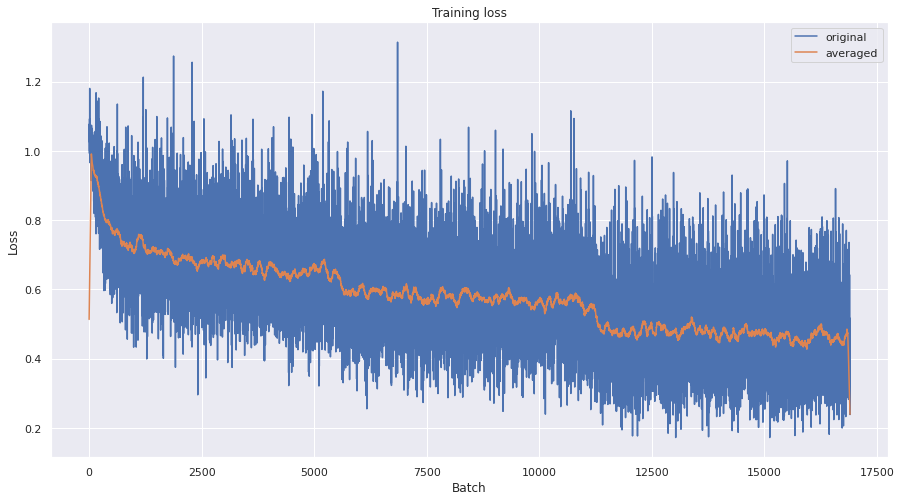

In [41]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

Evaluation

In [42]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [37257/50074] 0.7440
Classification report:
              precision    recall  f1-score   support

       Metal       0.72      0.47      0.57      4082
         Pop       0.83      0.64      0.73     21617
        Rock       0.70      0.88      0.78     24375

    accuracy                           0.74     50074
   macro avg       0.75      0.66      0.69     50074
weighted avg       0.76      0.74      0.74     50074

Confusion matrix:
[[ 1915   345  1822]
 [  275 13917  7425]
 [  472  2478 21425]]
